In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import librosa
import librosa.display
import IPython.display as ipd
from ipywidgets import interact, IntSlider
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Audio

# ==============================================================================
# PARÁMETROS GENERALES
# ==============================================================================

TARGET_SAMPLING_RATE = 16000 # Estandarizacion de la frecuencia de muestreo (SR) = 16000 Hz
N_MELS = 128                 # Altura de la imagen (N° de filtros Mel)
MAX_LENGTH = 125             # Ancho de la imagen (Frames de tiempo).

N_FFT = 1024                 # Tamaño de la ventana FFT
HOP_LENGTH = 512             # Desplazamiento entre ventanas FFT
DROPOUT_RATE = 0.5           # Tasa de Dropout para capas densas                   

NUM_CLASSES = 32             # Número de clases (identidades de ballenas) 
BATCH_SIZE = 32              # Tamaño del batch
LEARNING_RATE = 1e-4         # Tasa de aprendizaje
NUM_EPOCHS = 15               # Número de épocas de entrenamiento
 

# Clasificación de Cantos de Ballenas 🐋
Proyecto de aprendizaje supervisado usando el dataset **Marine Ocean Mammal Sound Dataset** (Hugging Face).

**Objetivo:** Explorar y preparar el dataset para un modelo de clasificación automática de cantos de ballenas y otros mamíferos marinos.


==============================================================================
### CARGA DE DATOS
==============================================================================

Dataset cargado: ardavey/marine_ocean_mammal_sound
Número de muestras en el split 'train': 1357
Columnas disponibles: ['audio', 'species', 'label']


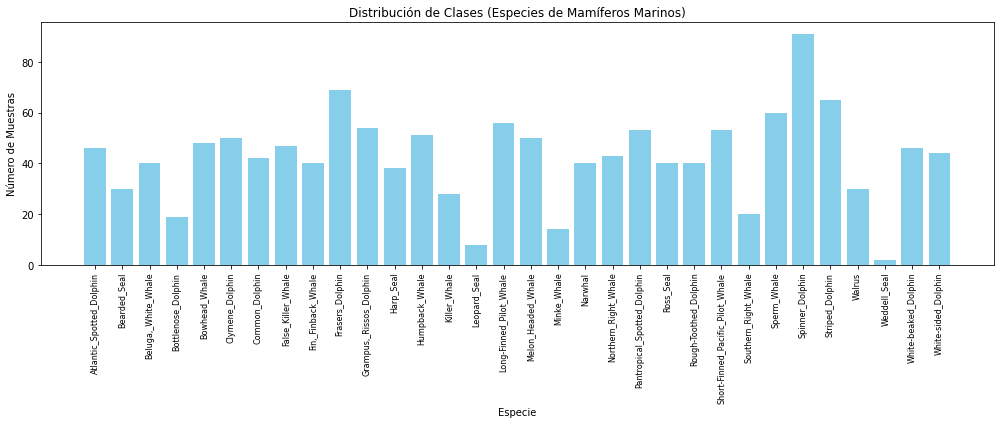

interactive(children=(IntSlider(value=0, description='Índice de Muestra', max=1356), Output()), _dom_classes=(…

In [ ]:
# ==============================================================================
# CARGA DEL DATASET
# ==============================================================================

# Nombre del dataset en Hugging Face
DATASET_NAME = "ardavey/marine_ocean_mammal_sound"

# Carga la división 'train' del dataset
dataset = load_dataset(DATASET_NAME, split='train')

print(f"Dataset cargado: {DATASET_NAME}")
print(f"Número de muestras en el split 'train': {len(dataset)}")
print(f"Columnas disponibles: {dataset.column_names}")

dataset = dataset.cast_column("audio", Audio(sampling_rate=TARGET_SAMPLING_RATE))

# ==============================================================================
# ANÁLISIS EXPLORATORIO: DISTRIBUCIÓN DE CLASES
# ==============================================================================

# Mapear las etiquetas numéricas a nombres de especies
label_names = dataset.features["label"].names
labels = [label_names[label] for label in dataset["label"]]
unique_labels, counts = np.unique(labels, return_counts=True)

# Visualizar la distribución de clases
plt.figure(figsize=(14, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title('Distribución de Clases (Especies de Mamíferos Marinos)')
plt.xlabel('Especie')
plt.ylabel('Número de Muestras')
plt.tight_layout()
plt.show()

# ==============================================================================
# EXPLORADOR INTERACTIVO DE MUESTRAS
# ==============================================================================

MAX_IDX = len(dataset) - 1

def explore_sample(idx):
    """
    Carga, reproduce y visualiza el espectrograma Mel para un índice dado.
    """
    sample = dataset[idx]
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    label = label_names[sample["label"]]

    print(f"--- Muestra Seleccionada: Índice {idx} ---") #Recordar: Fila n+2 Excel -> Indice n del dataset
    print(f"Especie: {label}")
    print(f"Frecuencia de Muestreo (SR): {sampling_rate} Hz")
    
    # Reproductor de Audio
    ipd.display(ipd.Audio(audio_array, rate=sampling_rate))
    
    # ----------------------------------------------------
    # A. Forma de Onda (Dominio del Tiempo)
    # ----------------------------------------------------
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(audio_array, sr=sampling_rate)
    plt.title(f'Forma de Onda: {label} (Índice {idx})')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

    # ----------------------------------------------------
    # B. Espectrograma Mel
    # ----------------------------------------------------
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_array,
        sr=sampling_rate,
        n_mels=N_MELS
    )

    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(
        mel_spectrogram_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Espectrograma Mel: {label} ({N_MELS} Mel Bins)')
    plt.tight_layout()
    plt.show()
    
# ==============================================================================
# WIDGET INTERACTIVO
# ==============================================================================

interact(
    explore_sample, 
    idx=IntSlider(min=0, max=MAX_IDX, step=1, value=0, description='Índice de Muestra')
);

==============================================================================
### ENTRENAMIENTO
==============================================================================

In [4]:
#CLASE DE DATASET PERSONALIZADA PARA PROCESAMIENTO
class MarineSoundDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        
        # 1. Extracción de Audio y Etiqueta
        audio_array = sample["audio"]["array"]
        sr = sample["audio"]["sampling_rate"]
        label = sample["label"] 
        
        # 2. Cálculo del Espectrograma Mel
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_array,
            sr=sr,
            n_mels=N_MELS,
            n_fft=N_FFT,      
            hop_length=HOP_LENGTH 
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # 3. Convertir a Tensor de PyTorch y añadir dimensión de canal (C, F, T)
        tensor = torch.tensor(mel_spectrogram_db).float().unsqueeze(0) 

        # 4. Truncamiento y Padding para tamaño fijo
        _, F, T = tensor.shape
        
        if T > MAX_LENGTH:
            start = (T - MAX_LENGTH) // 2
            tensor = tensor[:, :, start:start + MAX_LENGTH]
        elif T < MAX_LENGTH:
            padding = torch.zeros((1, F, MAX_LENGTH - T))
            tensor = torch.cat([tensor, padding], dim=2)
        
        return tensor, torch.tensor(label, dtype=torch.long)

In [5]:
#ARQUITECTURA DE RED NEURONAL CONVOLUCIONAL (CNN)
class SimpleWhaleClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, input_size=(N_MELS, MAX_LENGTH)):
        super(SimpleWhaleClassifier, self).__init__()
        
        # Bloque 1: (1, 128, 125) -> (16, 64, 62)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Bloque 2: (16, 64, 62) -> (32, 32, 31)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Bloque 3: (32, 32, 31) -> (64, 16, 15)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Cálculo del tamaño de la capa lineal (flatten)
        # 64 canales * (128/8) * (125/8) = 64 * 16 * 15 = 15360 (aproximadamente)
        final_height = input_size[0] // 8
        final_width = input_size[1] // 8
        self.flatten_size = 64 * final_height * final_width
        
        # Capas Densa
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, 1) 

        # Capas Densa
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
#ARQUITECTURA DE COMPARACIÓN (MÁS PROFUNDA)
class DeeperWhaleClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, input_size=(N_MELS, MAX_LENGTH)):
        super(DeeperWhaleClassifier, self).__init__()
        
        # Bloque 1: Aumenta a 32 canales
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # Salida: (32, 64, 62)
        
        # Bloque 2: Aumenta a 64 canales
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # Salida: (64, 32, 31)
        
        # Bloque 3: Aumenta a 128 canales
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # Salida: (128, 16, 15)

        # Bloque 4 (Añadido): Mantiene 128 canales, pero con más profundidad
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2) # Salida: (128, 8, 7)
        
        # Cálculo del tamaño de la capa lineal (flatten)
        final_height = input_size[0] // 16 # 128 / 16 = 8
        final_width = input_size[1] // 16 # 125 / 16 ~ 7
        self.flatten_size = 128 * final_height * final_width
        
        # Capas Densa
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Bloque 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Bloque 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Bloque 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Bloque 4
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Aplanar para la capa densa
        x = torch.flatten(x, 1) 
        
        # Capas Densa
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x

==============================================================================
### EJECUCIÓN PRINCIPAL
==============================================================================

In [7]:
def train_and_evaluate(model, model_name, train_loader, val_loader, device, epochs):
    """
    Función helper para entrenar y evaluar un modelo, retornando métricas finales y el historial.
    """
    print(f"\n=======================================================")
    print(f"  INICIANDO ENTRENAMIENTO: {model_name}")
    print(f"=======================================================")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_accuracy = 0.0
    start_time = time.time()
    
    # DICCIONARIO PARA ALMACENAR LAS CURVAS
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # ---------------------------------
        # BUCLE DE ENTRENAMIENTO
        # ---------------------------------
        for inputs, labels in tqdm(train_loader, desc=f" {model_name} Época {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss) # Guardar pérdida de entrenamiento

        # ---------------------------------
        # BUCLE DE EVALUACIÓN
        # ---------------------------------
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_predictions = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels) # Calcular la pérdida de validación
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        
        history['val_loss'].append(epoch_val_loss)      # Guardar pérdida de validación
        history['val_accuracy'].append(accuracy)        # Guardar precisión de validación
        
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy

        print(f"  RESULTADOS - Época {epoch+1}: Loss T/V={epoch_train_loss:.4f}/{epoch_val_loss:.4f} | Acc={accuracy:.2f}% | F1={f1:.4f}")

    end_time = time.time()
    total_time = end_time - start_time
    
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    final_results = {
        'name': model_name,
        'accuracy': best_accuracy,
        'f1_score': f1,
        'time_s': total_time,
        'parameters': num_params
    }

    return final_results, history


DATASET_NAME = "ardavey/marine_ocean_mammal_sound"
hf_dataset = load_dataset(DATASET_NAME, split='train')
hf_dataset = hf_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SAMPLING_RATE))

# 2. División de Datos (80% Entrenamiento, 20% Validación)
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = MarineSoundDataset(split_data["train"])
val_dataset = MarineSoundDataset(split_data["test"])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de entrenamiento: {device}")

model_simple = SimpleWhaleClassifier().to(device)
results_simple, history_simple = train_and_evaluate(model_simple, "SimpleWhaleClassifier", 
                                    train_loader, val_loader, device, NUM_EPOCHS)

model_deeper = DeeperWhaleClassifier().to(device)
results_deeper, history_deeper = train_and_evaluate(model_deeper, "DeeperWhaleClassifier", 
                                    train_loader, val_loader, device, NUM_EPOCHS)

print("\n\n#######################################################")
print("TABLA DE COMPARACIÓN FINAL PARA EL INFORME")
print("#######################################################")

comparison_df = pd.DataFrame([results_simple, results_deeper])
comparison_df['time_s'] = comparison_df['time_s'].round(2)
comparison_df['parameters'] = comparison_df['parameters'].apply(lambda x: f'{x:,}')

print(comparison_df.to_markdown(index=False))


Dispositivo de entrenamiento: cuda

  INICIANDO ENTRENAMIENTO: SimpleWhaleClassifier


 SimpleWhaleClassifier Época 1:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 1: Loss T/V=3.2986/3.0712 | Acc=23.16% | F1=0.1576


 SimpleWhaleClassifier Época 2:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 2: Loss T/V=2.9442/2.7251 | Acc=27.21% | F1=0.2141


 SimpleWhaleClassifier Época 3:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 3: Loss T/V=2.6568/2.4978 | Acc=38.24% | F1=0.3212


 SimpleWhaleClassifier Época 4:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 4: Loss T/V=2.4240/2.2942 | Acc=43.75% | F1=0.4016


 SimpleWhaleClassifier Época 5:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 5: Loss T/V=2.2410/2.1879 | Acc=44.85% | F1=0.4077


 SimpleWhaleClassifier Época 6:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 6: Loss T/V=2.0463/2.1213 | Acc=47.79% | F1=0.4489


 SimpleWhaleClassifier Época 7:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 7: Loss T/V=1.8937/1.9311 | Acc=54.41% | F1=0.5171


 SimpleWhaleClassifier Época 8:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 8: Loss T/V=1.7421/1.8419 | Acc=56.25% | F1=0.5367


 SimpleWhaleClassifier Época 9:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 9: Loss T/V=1.6312/1.7991 | Acc=54.04% | F1=0.5142


 SimpleWhaleClassifier Época 10:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 10: Loss T/V=1.5538/1.6992 | Acc=57.35% | F1=0.5523


 SimpleWhaleClassifier Época 11:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 11: Loss T/V=1.4554/1.6638 | Acc=58.09% | F1=0.5583


 SimpleWhaleClassifier Época 12:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 12: Loss T/V=1.3619/1.5996 | Acc=59.19% | F1=0.5746


 SimpleWhaleClassifier Época 13:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 13: Loss T/V=1.3109/1.5680 | Acc=61.76% | F1=0.6073


 SimpleWhaleClassifier Época 14:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 14: Loss T/V=1.1546/1.5277 | Acc=62.87% | F1=0.6131


 SimpleWhaleClassifier Época 15:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 15: Loss T/V=1.1262/1.5117 | Acc=62.13% | F1=0.6060

  INICIANDO ENTRENAMIENTO: DeeperWhaleClassifier


 DeeperWhaleClassifier Época 1:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 1: Loss T/V=3.1150/2.8827 | Acc=27.57% | F1=0.2118


 DeeperWhaleClassifier Época 2:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 2: Loss T/V=2.5690/2.3684 | Acc=39.34% | F1=0.3397


 DeeperWhaleClassifier Época 3:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 3: Loss T/V=2.1769/2.1053 | Acc=45.96% | F1=0.4292


 DeeperWhaleClassifier Época 4:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 4: Loss T/V=1.9265/1.8878 | Acc=52.21% | F1=0.4813


 DeeperWhaleClassifier Época 5:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 5: Loss T/V=1.6353/1.7863 | Acc=49.63% | F1=0.4534


 DeeperWhaleClassifier Época 6:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 6: Loss T/V=1.4587/1.5855 | Acc=57.35% | F1=0.5553


 DeeperWhaleClassifier Época 7:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 7: Loss T/V=1.3123/1.4803 | Acc=59.19% | F1=0.5672


 DeeperWhaleClassifier Época 8:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 8: Loss T/V=1.1034/1.4007 | Acc=59.93% | F1=0.5840


 DeeperWhaleClassifier Época 9:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 9: Loss T/V=1.0298/1.3118 | Acc=63.60% | F1=0.6186


 DeeperWhaleClassifier Época 10:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 10: Loss T/V=0.9347/1.2253 | Acc=67.28% | F1=0.6528


 DeeperWhaleClassifier Época 11:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 11: Loss T/V=0.8241/1.1397 | Acc=68.38% | F1=0.6727


 DeeperWhaleClassifier Época 12:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 12: Loss T/V=0.7238/1.1079 | Acc=68.01% | F1=0.6733


 DeeperWhaleClassifier Época 13:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 13: Loss T/V=0.6809/1.0737 | Acc=68.75% | F1=0.6815


 DeeperWhaleClassifier Época 14:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 14: Loss T/V=0.5878/1.0737 | Acc=67.65% | F1=0.6665


 DeeperWhaleClassifier Época 15:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(


  RESULTADOS - Época 15: Loss T/V=0.5547/1.0729 | Acc=70.22% | F1=0.6932


#######################################################
TABLA DE COMPARACIÓN FINAL PARA EL INFORME
#######################################################
| name                  |   accuracy |   f1_score |   time_s | parameters   |
|:----------------------|-----------:|-----------:|---------:|:-------------|
| SimpleWhaleClassifier |    62.8676 |   0.606046 |   847.96 | 1,993,856    |
| DeeperWhaleClassifier |    70.2206 |   0.693201 |   794.95 | 2,084,448    |


==============================================================================
### GENERACIÓN Y VISUALIZACIÓN DE LA MATRIZ DE CONFUSIÓN
==============================================================================

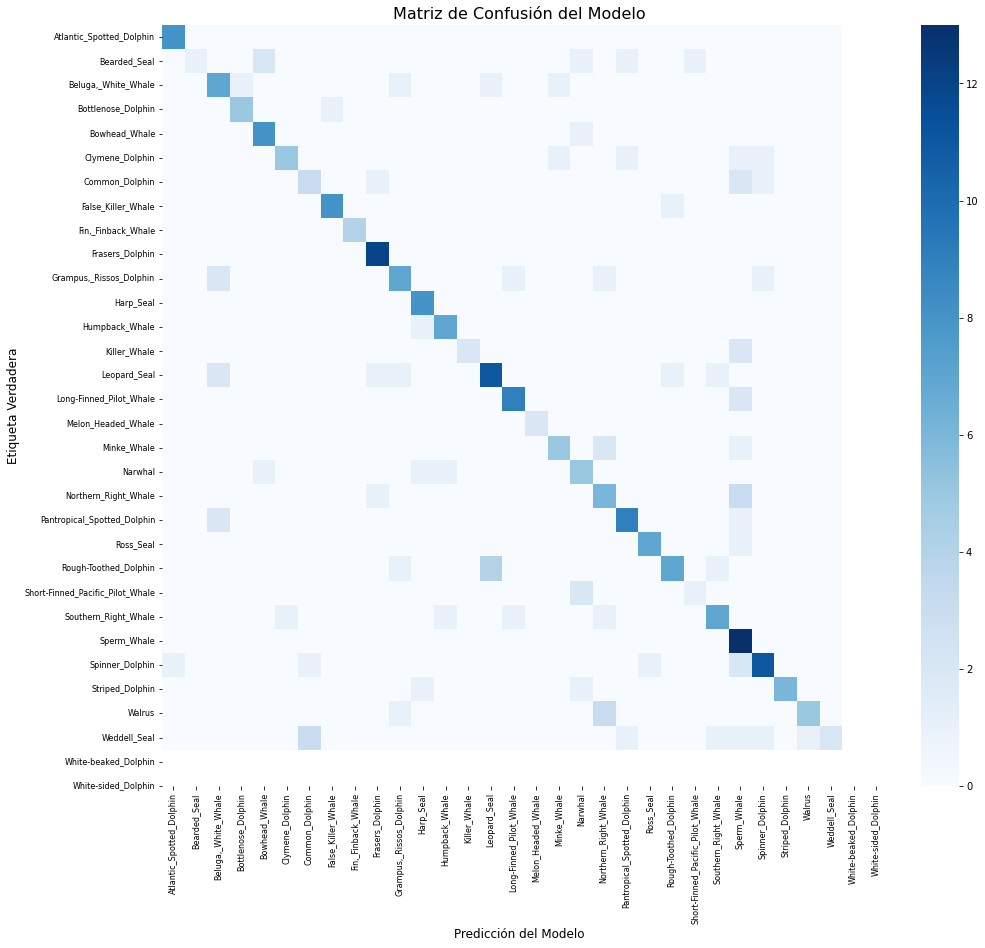


--- Análisis de la Matriz (Buscar los cuadros más brillantes fuera de la diagonal) ---


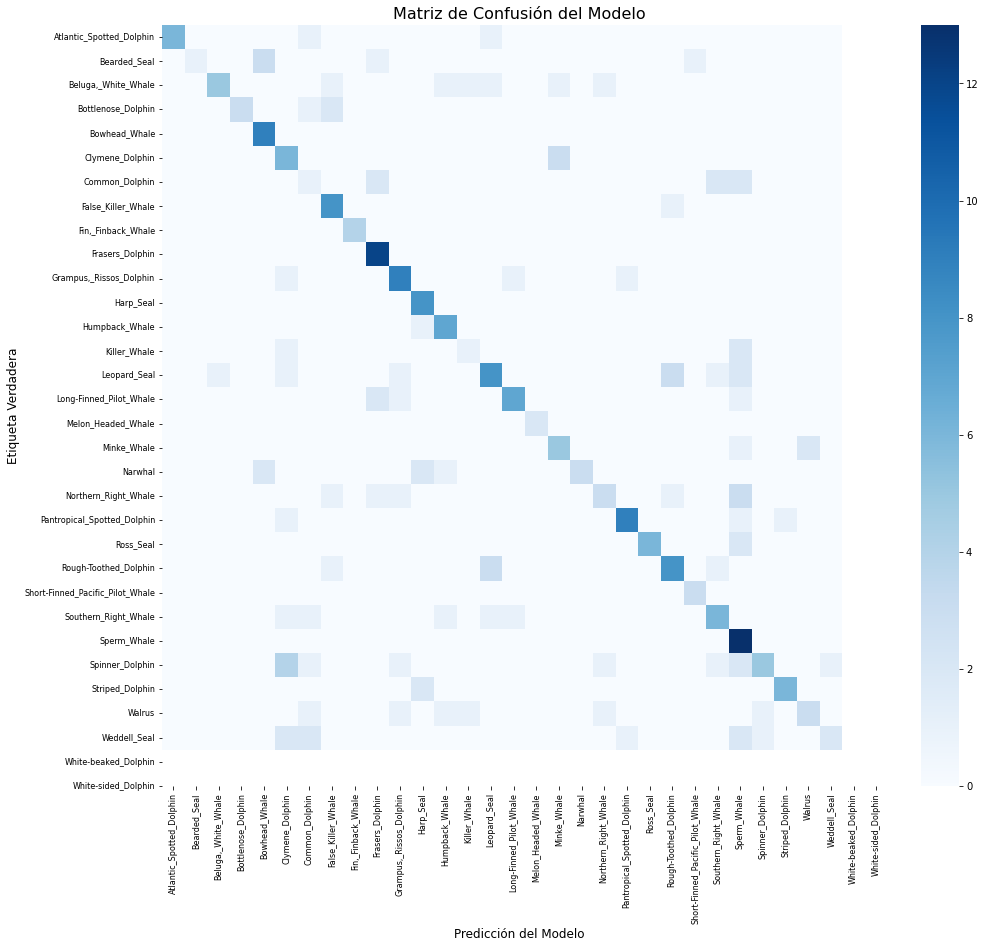


--- Análisis de la Matriz (Buscar los cuadros más brillantes fuera de la diagonal) ---


In [8]:
def plot_confusion_matrix(model, val_loader, device, label_names):
    """
    Evalúa el modelo en el set de validación y genera la Matriz de Confusión.
    """
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    # Calcular la Matriz de Confusión
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Visualización
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        cm, 
        annot=False,
        fmt='d', 
        cmap='Blues', 
        xticklabels=label_names, 
        yticklabels=label_names
    )
    plt.title('Matriz de Confusión del Modelo', fontsize=16)
    plt.ylabel('Etiqueta Verdadera', fontsize=12)
    plt.xlabel('Predicción del Modelo', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.show()
    
    print("\n--- Análisis de la Matriz (Buscar los cuadros más brillantes fuera de la diagonal) ---")

plot_confusion_matrix(model_deeper, val_loader, device, label_names)

plot_confusion_matrix(model_simple, val_loader, device, label_names)

==============================================================================
### 4. GRÁFICOS DE CURVAS DE PÉRDIDA Y PRECISIÓN
==============================================================================

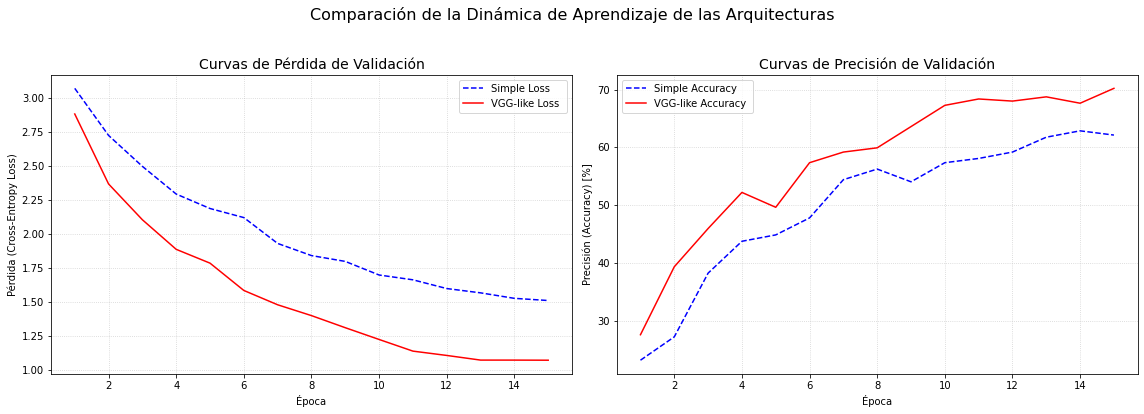

In [9]:
def plot_history(history_simple, history_deeper, epochs):
    """
    Genera dos gráficos: Curvas de Pérdida y Curvas de Precisión.
    """
    epochs_range = range(1, epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRÁFICO 1: CURVAS DE PÉRDIDA (LOSS) ---
    ax1.plot(epochs_range, history_simple['val_loss'], label='Simple Loss ', linestyle='--', color='blue')
    ax1.plot(epochs_range, history_deeper['val_loss'], label='VGG-like Loss ', linestyle='-', color='red')
    ax1.set_title('Curvas de Pérdida de Validación', fontsize=14)
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida (Cross-Entropy Loss)')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # --- GRÁFICO 2: CURVAS DE PRECISIÓN (ACCURACY) ---
    ax2.plot(epochs_range, history_simple['val_accuracy'], label='Simple Accuracy ', linestyle='--', color='blue')
    ax2.plot(epochs_range, history_deeper['val_accuracy'], label='VGG-like Accuracy ', linestyle='-', color='red')
    ax2.set_title('Curvas de Precisión de Validación', fontsize=14)
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión (Accuracy) [%]')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    plt.suptitle('Comparación de la Dinámica de Aprendizaje de las Arquitecturas', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Ejecutar la función de ploteo
plot_history(history_simple, history_deeper, NUM_EPOCHS)